[PIL ImageDraw (rectangle)](https://pillow.readthedocs.io/en/5.1.x/reference/ImageDraw.html) <br>

In [2]:
%matplotlib inline

## Initialize imports, define a data file management utility

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tempfile import TemporaryDirectory
from PIL import ImageDraw

import IPython.display as ip_display
import os
import sys
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import skimage
from skimage.filters import threshold_otsu

import openslide

import PIL
from PIL.Image import Image

"""       module import - commented out to use modified code below
sys.path.insert(0, '../src/python')
from openslide_2_tfrecord_module import *
"""

file_ext_list = ['.svs', '.tif', '.tiff']
def get_file_size_dict(data_dir, reverse_dict=False):
    """ Use to get size-ranked list of files in a directory:
    file_size_dict = get_file_size_dict(data_dir)
    """
    file_size_dict = {}
    for f in os.listdir(data_dir):
        ff = os.path.join(data_dir, f)
        if os.path.isfile(ff): 
            _, f_ext = os.path.splitext(ff)
            if f_ext in file_ext_list:
                file_size_dict[ff] = os.path.getsize(ff)
                
    return file_size_dict

## *openslide_2_tfrecord_module( )* Code change exprimentation

In [3]:
WORKING_THUMB_MAX_SIZE = [2048, 2048]
WORKING_THUMB_MIN_SIZE = [1024, 1024]

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#                                                                                NEW Start    <o><o>
def image_patch(image_string, label, ulc_row, ulc_col, lrc_row, lrc_col, image_name='patch'):
    """ image_metadat_dict = image_example(image_string, label, image_name)
    Create a dictionary of jpg image features
    Args:
        image_string:  bytes(PIL_image)
        label:         a number
        image_name:    bytes(image_name)
    Returns:
        one_tf_train_example: tf.train.Example 
    """
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {'height': _int64_feature(image_shape[0]),
               'width': _int64_feature(image_shape[1]),
               'depth': _int64_feature(image_shape[2]),
               'ulc_row': _int64_feature(ulc_row),
               'ulc_col': _int64_feature(ulc_col),
               'lrc_row': _int64_feature(lrc_row),
               'lrc_col': _int64_feature(lrc_col),
               'label': _int64_feature(label), 
               'image_name': _bytes_feature(image_name),
               'image_raw': _bytes_feature(image_string) }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def _parse_image_patch_function(example_proto):
    """ reader for image_example() encoded as tfrecord file 
        usage:
    parsed_image_dataset = tf.data.TFRecordDataset(tfrecord_name).map(_parse_image_function)
    
    Args: 
        example_proto:
        
    Returns:
        iterable_tfrecord:   try iterable_tfrecord.__iter__()
    """
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'ulc_row': tf.io.FixedLenFeature([], tf.int64),
        'ulc_col': tf.io.FixedLenFeature([], tf.int64),
        'lrc_row': tf.io.FixedLenFeature([], tf.int64),
        'lrc_col': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string) }

    return tf.io.parse_single_example(example_proto, image_feature_description)


def get_iterable_tfrecord(tfr_name):
    """ usage:
    iterable_tfrecord = get_iterable_tfrecord(tfr_name)
    
    Args:
        tfr_name:   tensorflow data TFRecord file
        
    Returns:
        TFRecordDataset_map_object:  tf.data.TFRecordDataset().map()
        
    """
    return tf.data.TFRecordDataset(tfr_name).map(_parse_image_patch_function)
#                                                                                NEW End      <o><o>


def get_adjcent_segmented_length_fence_array(segment_length, length):
    """ Usage - still developing:
    fences = get_adjcent_segmented_length_fence_array(segment_length, length)
    
    Args:
        segment_length: patch size - number of pixels high or wide 
        length:         overall number of pixels high or wide 
        
    Returns:
        fences:         n x 2 array for [top, bottom] or [height, width] usage
                        Note that images are numbered from top to bottom
    """
    # allocate the return container 
    fences = {}
    n_fenced = length // segment_length           # overall length divided by patch size  >> number of boxes
    n_remain = 1 + length % segment_length        # remaining number of pixels
    paddit = n_remain // 2                        # padding for the beginning and end of the boxed section
    if n_remain == segment_length:                # if exactly one box is left over special case
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    # allocate the array
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):                     # for each box edge, get the beginning and end pixel location
        if k == 0:                                # first case special: start with padding
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
                                                  # Use the previous right pixel plus one 
            fence_array[k, 0] = fence_array[k-1, 1] + 1
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
                                                  # add one width to the left pixel in this segment
                
    # return everything for development debug    
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences

        
def get_patch_name_from_row_col(row, col, base_name='patch', file_ext='.jpg'):
    """ Usage:
    patch_name = get_patch_name_from_row_col(row,col,base_name='patch',file_ext='.jpg') 
    
    Args:
        row, col:       integer list e.g row = [0, 20]
        base_name:      beginning of the file name
        file_ext:       default is '.jpg' Note: include the period before the name
        
    Returns:
        patch_name:     file name (without directory path)
    """
    if file_ext[0] != '.':
        file_ext = '.' + file_ext
    patch_name = base_name + '_row_%i_%i'%(row[0], row[1])
    patch_name += '_col_%i_%i%s'%(col[0], col[1], file_ext)
    
    return patch_name


def get_row_col_from_patch_name(fname):
    """ Usage:
    row_col_dict = get_row_col_from_filename(fname) 
    
    Args:
        fname:          file name as created by this module function:
                        get_patch_name_from_row_col(row, col, base_name, file_ext)
    Returns:
        row_col_dict: { 'base_name': parts_list[0], 
                        'file_ext': file_ext, 
                        'row': row, 
                        'col': col }
    """
    row_label = 'row'
    col_label = 'col'
    r = []
    c = []
    base_name, file_ext = os.path.splitext(os.path.split(fname)[1])
    parts_list = base_name.split('_')
    
    for i in range(len(parts_list)):
        if parts_list[i] == row_label:
            r.append(parts_list[i+1])
            r.append(parts_list[i+2])
        elif parts_list[i] == col_label:
            c.append(parts_list[i+1])
            c.append(parts_list[i+2])
    row = np.array(r).astype(np.int)
    col = np.array(c).astype(np.int)
    
    return {'base_name': parts_list[0], 'file_ext': file_ext, 'row': row, 'col': col }


def get_mask_w_scale_grid(os_obj, patch_height, patch_width, thumbnail_divisor=None):
    """ Usage:
    mask_dict = get_mask_w_scale_grid(svs_file_name, patch_height, patch_width, thumbnail_divisor=None)
    
    Args:
        os_obj:         file name or opened OpenSlide object
        patch_height:   how high to make the patch indices
        patch_width:    how wide to make the patch indices
    
    Returns:
        mask_dict:      {'thumb_mask': mask_im, 
                         'full_scale_rows_dict': full_scale_rows_dict, 
                         'full_scale_cols_dict': full_scale_cols_dict, 
                         'full_scale_rows_arrays': full_scale_rows_arrays, 
                         'full_scale_cols_arrays': full_scale_cols_arrays,
                         'thumb_scale_rows_arrays': thumb_scale_rows_arrays, 
                         'thumb_scale_cols_arrays': thumb_scale_cols_arrays }
    """
    # don't close if it was passed in, close if it was opened in this function
    close_os_obj = False
    if isinstance(os_obj, str) and os.path.isfile(os_obj):
        os_obj = openslide.OpenSlide(os_obj)
        close_os_obj = True
    
    #                                                                                NEW fix start    <o><o>
    #                               get the indexing arrays for the full size grid
    pixels_height = os_obj.dimensions[1]
    pixels_width = os_obj.dimensions[0]

    full_scale_rows_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_height, 
                                                                    length=pixels_height)
    full_scale_cols_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_width, 
                                                                    length=pixels_width)
    full_scale_rows_arrays = full_scale_rows_dict['fence_array']
    full_scale_cols_arrays = full_scale_cols_dict['fence_array']
    
    #                               determine thumbnail size & get the mask
    pixels_height_ds = os_obj.level_dimensions[-1][1]
    pixels_width_ds = os_obj.level_dimensions[-1][0]
    #                                                                                NEW fix end       <o><o>
    
    if thumbnail_divisor is None:
        thumbnail_divisor = 1
        while_stopper = 20
        count = 0

        scale_determinant = max(pixels_height_ds, pixels_width_ds)
        while scale_determinant // thumbnail_divisor > WORKING_THUMB_MAX_SIZE[0] and count < while_stopper:
            count += 0
            thumbnail_divisor *= 2
    
    thumb_height = pixels_height_ds // thumbnail_divisor
    thumb_width = pixels_width_ds // thumbnail_divisor
    
    #                               get the indexing arrays for the thumbnail sized grid
    rows_divisor = pixels_height / thumb_height
    thumb_scale_rows_arrays = (full_scale_rows_arrays // rows_divisor).astype(int)
    cols_divisor = pixels_width / thumb_width
    thumb_scale_cols_arrays = (full_scale_cols_arrays // cols_divisor).astype(int)

    #                               git the mask image
    one_thumb = os_obj.get_thumbnail((thumb_height, thumb_width))
    grey_thumbnail = np.array(one_thumb.convert('L'))
    thresh = threshold_otsu(grey_thumbnail)
    mask = np.array(grey_thumbnail) < thresh
    mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)
    
    # close if it was opened in this function - don't close if it was passed in
    if close_os_obj == True:
        os_obj.close()
        
    mask_dict = {'one_thumb': one_thumb,
                 'thumb_mask': mask_im, 
                 'thumbnail_divisor': thumbnail_divisor,
                 'full_scale_rows_dict': full_scale_rows_dict, 
                 'full_scale_cols_dict': full_scale_cols_dict, 
                 'full_scale_rows_arrays': full_scale_rows_arrays, 
                 'full_scale_cols_arrays': full_scale_cols_arrays,
                 'thumb_scale_rows_arrays': thumb_scale_rows_arrays, 
                 'thumb_scale_cols_arrays': thumb_scale_cols_arrays}
    
    return mask_dict


def svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_size, drop_threshold, file_ext=None):
    """ Usage:
    report_dict = svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_size, drop_threshold, file_ext)
    
    Args:
        svs_file_name:   accessable path file name
        output_dir:      writeable directory for the tfrecord
        patch_size:      list of 2 integers: [224, 224] or an integer if square
        drop_threshold:  number between 0 & 1 -- if the masked area of the patch is smaller it is included
        file_ext:        default is '.jpg' ('.png') was tested (Note the period is included)
        
    Returns:
        svs_file_conversion_dict:  {'mask_dict': mask_dict, 
                                    'tfrecord_file_name': tfrecord_file_name, 
                                    'number_of_patches': seq_number, 
                                    'temp_dir': temp_dir }
    """
    
    # construct file nameing variables from svs_file_name, output_dir, set file_ext if missing
    _, file_name_base = os.path.split(svs_file_name)
    file_name_base, _ = os.path.splitext(file_name_base)
    tfrecord_file_name = file_name_base + '.tfrecords'
    tfrecord_file_name = os.path.join(output_dir, tfrecord_file_name)
    if file_ext is None:
        file_ext = '.jpg'
        
    # expand patch size into both height and width
    if isinstance(patch_size, list) and len(patch_size) == 2:
        patch_height = patch_size[0]
        patch_width = patch_size[1]
    else:
        patch_height = patch_width = patch_size
    
    # get the OpenSlide object - open the file, and get the mask with the scaled grids
    os_obj = openslide.OpenSlide(svs_file_name)
    mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
    """
                        Break-out option
                        mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
    """
    # convert the dictionary to named variables for clarity
    mask_im = mask_dict['thumb_mask']
    full_scale_rows_arrays = mask_dict['full_scale_rows_arrays']
    full_scale_cols_arrays = mask_dict['full_scale_cols_arrays']
    thumb_scale_rows_arrays = mask_dict['thumb_scale_rows_arrays']
    thumb_scale_cols_arrays = mask_dict['thumb_scale_cols_arrays']
    
    seq_number = 0
    # open a temporary directory and a TFRecordWriter object
    with TemporaryDirectory() as temp_dir:
        with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
            
            # iterate through the rows and columns of patches
            for row in range(full_scale_rows_arrays.shape[0]):
                for col in range(full_scale_cols_arrays.shape[0]):
                    # get the small segment of the mask with PIL ordering for crop
                    r = thumb_scale_rows_arrays[row]
                    c = thumb_scale_cols_arrays[col]
                    area = (c[0], r[0], c[1], r[1])
                    thumb_segment = mask_im.crop(area)
                    thumb_arr = np.array(thumb_segment)
                    """
                            Break-out option
                            mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
                    """
                    # evaluate the thumb_segment - reject if the masked (dark area) is too large
                    mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))
                    if mask_value <= drop_threshold:
                        # put row=(top, bottom) & column=(left, right) fence arrays into PIL format
                        fs_row = full_scale_rows_arrays[row]
                        fs_col = full_scale_cols_arrays[col]
                        read_location = (full_scale_cols_arrays[col][0], full_scale_rows_arrays[row][0])
                        
                        # build the full-path patch name in the temp dir
                        patch_name = get_patch_name_from_row_col(fs_row, fs_col, file_name_base, file_ext)
                        patch_full_name = os.path.join(temp_dir, patch_name)

                        # let OpenSlide extract the (PIL) patch, convert to RGB & save temporary
                        full_sect = os_obj.read_region(level=0, size=patch_size, location=read_location)
                        full_sect = full_sect.convert('RGB')                                                
                        full_sect.save(patch_full_name)
                        
                        # add the file to the tfrecord
                        image_string = open(patch_full_name, 'rb').read()
                        tf_example_obj = image_patch(image_string, 
                                                     label=seq_number, 
                                                     ulc_row=r[0], 
                                                     ulc_col=c[0], 
                                                     lrc_row=r[1], 
                                                     lrc_col=c[1],
                                                     image_name=bytes(patch_name,'utf8'))
                        
                        writer.write(tf_example_obj.SerializeToString())
                        seq_number += 1

    # prototype a return report - what is really needed?
    svs_file_conversion_dict = {'mask_dict': mask_dict, 
                                'tfrecord_file_name': tfrecord_file_name, 
                                'number_of_patches': seq_number, 
                                'temp_dir': temp_dir}
    
    return svs_file_conversion_dict


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 361)

## Display the size-ranked list of image files by Directory

In [5]:
data_dir = '../../DigiPath_MLTK_data/Aperio'

file_size_dict = get_file_size_dict(data_dir)
rev_file_size_dict = {v:k for k, v in file_size_dict.items()}

ordered_keys = sorted(list(file_size_dict.values()))
files_list = []
for k in ordered_keys:
    files_list.append(rev_file_size_dict[k])

print('\nordered by size:\n')
count = 0
for f in files_list:
    _, f_only = os.path.split(f)
    print('%3i %30s: %i'%(count, f_only, file_size_dict[f]))
    count += 1


ordered by size:

  0         CMU-1-Small-Region.svs: 1938955
  1               JP2K-33003-1.svs: 63847265
  2           CMU-1-JP2K-33005.svs: 132565343
  3                      CMU-1.svs: 177552579
  4                      CMU-3.svs: 253815723
  5               JP2K-33003-2.svs: 289250433
  6                      CMU-2.svs: 390750635


## Adapt function - *svs_file_to_patches_tfrecord(...)* to place boxes on thumbnail

39 patches in tfrecord_file_name: ../../DigiPath_MLTK_data/thumb_test/CMU-1-Small-Region.tfrecords


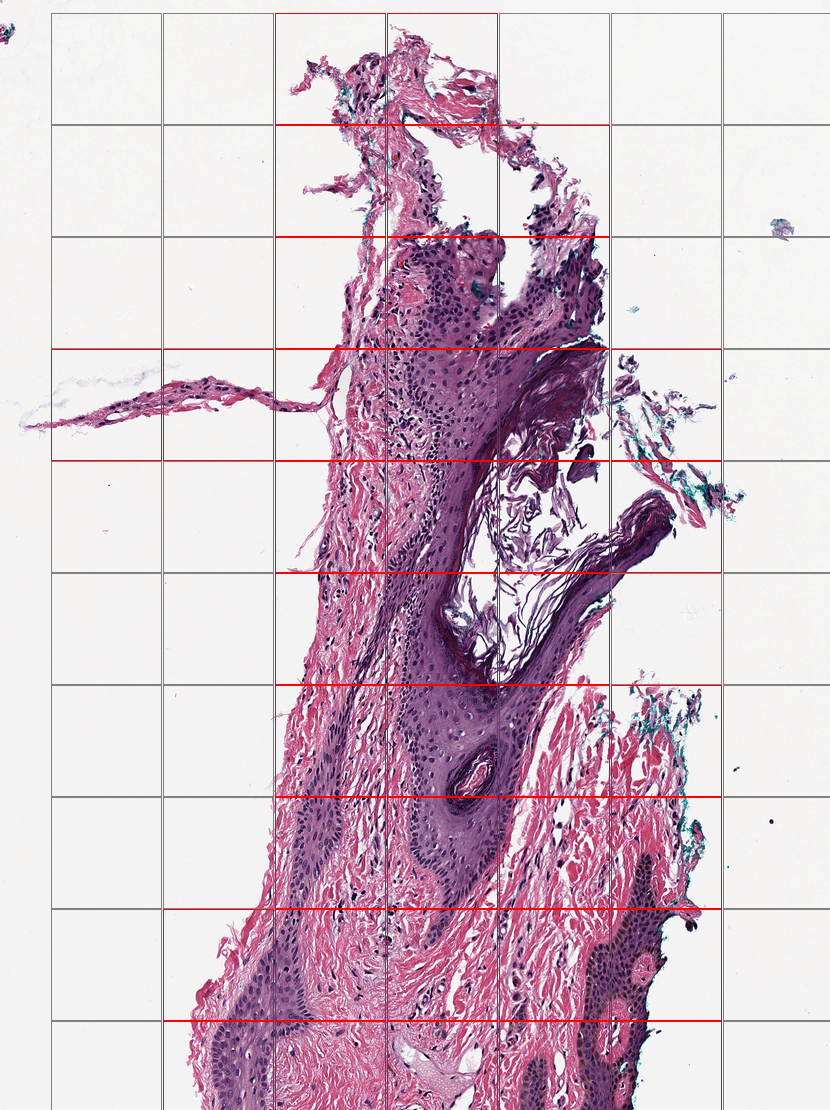

In [15]:
"""
        Prototype revision to svs_file_to_patches_tfrecord - 
        
        Sleep on what dictionary items to include,
        Note that the draw rectangle part is moved into other functions - just here for development tracking
        
"""
def box_it_up_scotty(svs_file_name, output_dir, patch_size, drop_threshold, file_ext=None):
    """ Usage:
    report_dict = box_it_up_scotty(svs_file_name, output_dir, patch_size, drop_threshold, file_ext)
    """
    # construct file nameing variables from svs_file_name, output_dir, set file_ext if missing
    _, file_name_base = os.path.split(svs_file_name)
    file_name_base, _ = os.path.splitext(file_name_base)
    
    tfrecord_file_name = file_name_base + '.tfrecords'
    tfrecord_file_name = os.path.join(output_dir, tfrecord_file_name)

    if file_ext is None:
        file_ext = '.jpg'
        
    # expand patch size into both height and width
    if isinstance(patch_size, list) and len(patch_size) == 2:
        patch_height = patch_size[0]
        patch_width = patch_size[1]
    else:
        patch_height = patch_width = patch_size
    
    # get the OpenSlide object - open the file, and get the mask with the scaled grids
    os_obj = openslide.OpenSlide(svs_file_name)
    mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
    
    #                                                                       NEW     <o><o>
    # to mark up the thumbnail with boxes
    mtim = mask_dict['one_thumb'].convert('RGBA')
    mtim_draw = ImageDraw.Draw(mtim)
    #                                                                       NEW     <o><o>
    
    # convert the dictionary to named variables for clarity    
    mask_im = mask_dict['thumb_mask']
    full_scale_rows_arrays = mask_dict['full_scale_rows_arrays']
    full_scale_cols_arrays = mask_dict['full_scale_cols_arrays']
    thumb_scale_rows_arrays = mask_dict['thumb_scale_rows_arrays']
    thumb_scale_cols_arrays = mask_dict['thumb_scale_cols_arrays']
    
    seq_number = 0
    # open a temporary directory and a TFRecordWriter object
    with TemporaryDirectory() as temp_dir:
        with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
            # iterate through the rows and columns of patches
            for row in range(full_scale_rows_arrays.shape[0]):
                for col in range(full_scale_cols_arrays.shape[0]):
                    # get the small segment of the mask with PIL ordering for crop
                    r = thumb_scale_rows_arrays[row]
                    c = thumb_scale_cols_arrays[col]
                    area = (c[0], r[0], c[1], r[1])
                    thumb_segment = mask_im.crop(area)
                    thumb_arr = np.array(thumb_segment)

                    # evaluate the thumb_segment - reject if the masked (dark area) is too large
                    mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))
                    if mask_value <= drop_threshold:
                        # put row=(top, bottom) & column=(left, right) fence arrays into PIL format
                        fs_row = full_scale_rows_arrays[row]
                        fs_col = full_scale_cols_arrays[col]
                        read_location = (full_scale_cols_arrays[col][0], full_scale_rows_arrays[row][0])

                        # build the full-path patch name in the temp dir
                        patch_name = get_patch_name_from_row_col(fs_row, fs_col, file_name_base, file_ext)
                        patch_full_name = os.path.join(temp_dir, patch_name)

                        # let OpenSlide extract the (PIL) patch, convert to RGB & save temporary
                        full_sect = os_obj.read_region(level=0, size=patch_size, location=read_location)
                        full_sect = full_sect.convert('RGB')                                                
                        full_sect.save(patch_full_name)

                        #                                                                   NEW     <o><o>
                        # add the file to the tfrecord
                        image_string = open(patch_full_name, 'rb').read()

                        tf_example_obj = image_patch(image_string, 
                                                     label=seq_number, 
                                                     ulc_row=fs_row[0], 
                                                     ulc_col=fs_col[0],
                                                     lrc_row=fs_row[1], 
                                                     lrc_col=fs_col[1],
                                                     image_name=bytes(patch_name,'utf8'))

                        seq_number += 1
                        mtim_draw.rectangle(((c[0], r[0]), (c[1]-1, r[1]-1)), outline='red', fill=None)
                        
                        writer.write(tf_example_obj.SerializeToString())
                        
                    else:
                        mtim_draw.rectangle(((c[0], r[0]), (c[1]-1, r[1]-1)), outline='gray', fill=None)
                    #                                                                       NEW     <o><o>

    # prototype a return report - what is really needed?
    svs_file_conversion_dict = {'mask_dict': mask_dict, 
                                'mtim_thumb': mtim,
                                'number_of_patches': seq_number, 
                                'temp_dir': temp_dir, 
                                'tfrecord_file_name': tfrecord_file_name}
    
    return svs_file_conversion_dict


svs_file_name = os.path.join(data_dir, files_list[0]) # 'CMU-1-Small-Region.svs'

output_dir = '../../DigiPath_MLTK_data/thumb_test'
if os.path.isdir(output_dir) == False:
    print(output_dir, '\n\tnot found')
patch_height = 224
patch_width = 224
patch_size = [patch_height, patch_width]
patch_keep_threshold = 0.9
drop_threshold = patch_keep_threshold

report_dict = box_it_up_scotty(svs_file_name, output_dir, patch_size, drop_threshold)
print(report_dict['number_of_patches'], 'patches in tfrecord_file_name:', report_dict['tfrecord_file_name'])
mtim = report_dict['mtim_thumb']

display(mtim)

## Get the location of the tfrecord images on a thumbnail image

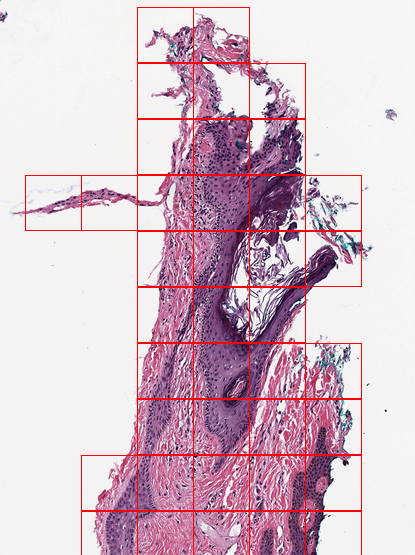

In [14]:
"""     tfrecord filename, wsi filename and requested thumbnail image scale (eg 1/2 1/10)
        
        get the location of the images in the tfrecord on a thumbnail image
"""
def get_marked_thumbnail(tfrecord_filename, wsi_filename, thumb_scale):
    """ Usage: marked_thumbnail = get_marked_thumbnail(tfrecord_filename, wsi_filename, thumb_scale)
    """
    # open the WSI - get FSI size & get thumbnail, make a grayscale copy as "RGBA" & calculate scale
    os_obj = openslide.OpenSlide(wsi_filename)
    pixels_height = np.int(os_obj.dimensions[1] * thumb_scale)
    pixels_width = np.int(os_obj.dimensions[0] * thumb_scale)
    one_thumb = os_obj.get_thumbnail((pixels_height, pixels_width)).convert('RGBA')    
    #     thumbnail_divisor = 1 / thumb_scale
    #     mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width, thumbnail_divisor)
    #     one_thumb = mask_dict['one_thumb'].convert('RGBA')
    one_thumb_draw = ImageDraw.Draw(one_thumb)
    
    iterable_tfrecord = get_iterable_tfrecord(tfrecord_filename).__iter__()
    is_empty = False
    while is_empty == False:
        try:
            patch_record = iterable_tfrecord.next()
            image_raw = patch_record['image_raw'].numpy()
            ulc_row = np.int(patch_record['ulc_row'].numpy() * thumb_scale)
            ulc_col = np.int(patch_record['ulc_col'].numpy() * thumb_scale)
            lrc_row = np.int(patch_record['lrc_row'].numpy() * thumb_scale)
            lrc_col = np.int(patch_record['lrc_col'].numpy() * thumb_scale)
            one_thumb_draw.rectangle(((ulc_col, ulc_row), (lrc_col, lrc_row)), outline='red', fill=None)
        except StopIteration:
            is_empty = True
            pass
    
    return one_thumb
tfrecord_filename = '../../DigiPath_MLTK_data/thumb_test/CMU-1-Small-Region.tfrecords'
wsi_filename = os.path.join(data_dir, files_list[0]) # 'CMU-1-Small-Region.svs'
thumb_scale = 1/4

marked_thumbnail = get_marked_thumbnail(tfrecord_filename, wsi_filename, thumb_scale)
display(marked_thumbnail)

## Show the color images on grayscale of mask

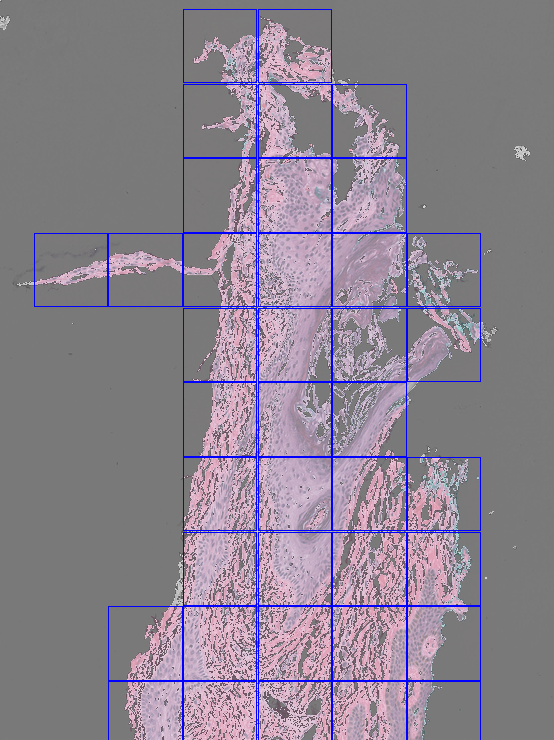

In [12]:
def get_masked_thumbnail(tfrecord_filename, wsi_filename, thumb_scale, alpha):
    # open the WSI - get FSI size & get thumbnail, make a grayscale copy as "RGBA" & calculate scale
    os_obj = openslide.OpenSlide(wsi_filename)
    pixels_height = np.int(os_obj.dimensions[1] * thumb_scale)
    pixels_width = np.int(os_obj.dimensions[0] * thumb_scale)
    
    thumbnail_divisor = 1 / thumb_scale
    mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width, thumbnail_divisor)
    one_thumb = mask_dict['one_thumb'].convert('RGBA')
    one_gray_thumb = one_thumb.convert('L')
    one_gray_thumb = one_gray_thumb.convert('RGBA')
    black_mask = mask_dict['thumb_mask'].convert('RGBA')
    
    # also see PIL.Image:  composite
    thumb_mask = PIL.Image.blend(one_gray_thumb, black_mask, alpha)
    one_thumb = PIL.Image.blend(one_thumb, black_mask, alpha)
    one_thumb_draw = ImageDraw.Draw(one_thumb)
    
    iterable_tfrecord = get_iterable_tfrecord(tfrecord_filename).__iter__()
    is_empty = False
    while is_empty == False:
        try:
            patch_record = iterable_tfrecord.next()
            image_raw = patch_record['image_raw'].numpy()
            ulc_row = np.int(patch_record['ulc_row'].numpy() * thumb_scale)
            ulc_col = np.int(patch_record['ulc_col'].numpy() * thumb_scale)
            lrc_row = np.int(patch_record['lrc_row'].numpy() * thumb_scale)
            lrc_col = np.int(patch_record['lrc_col'].numpy() * thumb_scale)
            box_bound = (ulc_col, ulc_row, lrc_col, lrc_row)
            patch_im = one_thumb.crop(box_bound).convert('RGBA')
            patch_draw = ImageDraw.Draw(patch_im)
            h = patch_im.size[0]
            w = patch_im.size[1]
            patch_draw.rectangle(((0, 0), (h-1, w-1)), outline='blue', fill=None)
            
            offset = (ulc_col, ulc_row)
            thumb_mask.paste(patch_im, offset)

        except StopIteration:
            is_empty = True
            pass
    
    return thumb_mask

tfrecord_filename = '../../DigiPath_MLTK_data/thumb_test/CMU-1-Small-Region.tfrecords'
wsi_filename = os.path.join(data_dir, files_list[0]) # 'CMU-1-Small-Region.svs'  (better if from tfrecord)
# size of thumbnail relative to wsi
thumb_scale = 1/3
# larger alpha is darker mask
alpha = 0.5

one_thumb = get_masked_thumbnail(tfrecord_filename, wsi_filename, thumb_scale, alpha)
display(one_thumb)

## Notes how to parts reference

### "crop" copys a box
```python
one_thumb = mask_dict['one_thumb']
grey_thumb = one_thumb.convert('L')
grey_thumb = grey_thumb.convert('RGBA')

# draw.rectangle(((101, 101), (200, 200)), outline='blue', fill=None)
# left, upper, right, lower
lft = 250
uppr = 300
rght = lft+224
lwr = uppr+224
box = (lft,uppr,rght,lwr)
sm_box = one_thumb.crop(box)
smaller_box = sm_box.resize((64,64))
print('type(smaller_box):\t',type(smaller_box))
display(sm_box)
display(smaller_box)
smaller_box.size
```

### "draw" makes a border
```python
mtim = smaller_box.convert('RGBA')
draw = ImageDraw.Draw(mtim)
h = mtim.size[0]
w = mtim.size[1]

draw.rectangle(((0, 0), (h-1, w-1)), outline='red', fill=None)
mtim.convert('RGB')
display(mtim)
```

### "paste" puts a boxed rectangle back to its location
```python
sm_box_boxed = sm_box.convert('RGBA')
h = sm_box_boxed.size[0] - 1
w = sm_box_boxed.size[1] - 1
sm_box_draw = ImageDraw.Draw(sm_box_boxed)
sm_box_draw.rectangle(((0,0), (h, w)), outline='blue', fill=None)

lft = 250
uppr = 300
offset = (lft,uppr)
grey_thumb.paste(sm_box_boxed, offset)
display(grey_thumb)
```

#### also see PIL.Image:  blend, composite
[PIL docs](https://pillow.readthedocs.io/en/5.1.x/reference/Image.html#image-processing) <br>